# Feature exploration

In [1]:
import numpy as np
import pandas as pd
import matplotlib
matplotlib.use('nbagg')
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.io import fits
import os
import sys
sys.path.append('../')
from setup import *
import seaborn as sns
from spectral_cube import SpectralCube
%matplotlib widget

In [2]:
feature_table = 'feature_table_aic.csv'
normalize=True

In [3]:
cube = SpectralCube.read(hc3n_10_9_cube+'.fits')

In [4]:
np.shape(cube.spatial_coordinate_map)

(2, 525, 464)

In [5]:
np.shape(fits.getdata(fitfilebase.format(1)+'_aic.fits'))

(6, 525, 464)

In [6]:

if not os.path.exists(feature_table):
    params1g, params1gheader = fits.getdata(fitfilebase.format(1)+'_aic.fits', header=True)
    params2g = fits.getdata(fitfilebase.format(2)+'_aic.fits')
    xarray = np.linspace(0, params1gheader['NAXIS1']-1, params1gheader['NAXIS1'])
    yarray = np.linspace(0, params1gheader['NAXIS2']-1, params1gheader['NAXIS2'])
    xx, yy = np.meshgrid(xarray, yarray)
    xx_params = np.array([xx, xx, xx])
    yy_params = np.array([yy, yy, yy])
    ra_params = np.array([cube.spatial_coordinate_map[1]]*3)
    dec_params = np.array([cube.spatial_coordinate_map[0]]*3)
    xx_props = xx_params.flatten()
    yy_props = yy_params.flatten()
    ra_props = ra_params.flatten()
    dec_props = dec_params.flatten()
    
    amplitudes = np.array([params1g[0], params2g[0], params2g[3]]).flatten()
    e_amplitudes = np.array([params1g[3], params2g[6], params2g[9]]).flatten()
    cent_velocities = np.array([params1g[1], params2g[1], params2g[4]]).flatten()
    e_cent_velocities = np.array([params1g[4], params2g[7], params2g[10]]).flatten()
    sigma_vs = np.array([params1g[2], params2g[2], params2g[5]]).flatten()
    e_sigma_vs = np.array([params1g[5], params2g[8], params2g[11]]).flatten()
    # we first load all the features
    index_stay = np.where(~np.isnan(amplitudes))
    amplitudes = amplitudes[index_stay]
    e_amplitudes = e_amplitudes[index_stay]
    cent_velocities = cent_velocities[index_stay]
    e_cent_velocities = e_cent_velocities[index_stay]
    sigma_vs = sigma_vs[index_stay]
    e_sigma_vs = e_sigma_vs[index_stay]
    xx_props = xx_props[index_stay]
    yy_props = yy_props[index_stay]
    ra_props = ra_props[index_stay]
    dec_props = dec_props[index_stay]
    
    ds_feats = pd.DataFrame(data=np.transpose([xx_props, yy_props, ra_props, dec_props, amplitudes, cent_velocities, sigma_vs]), 
                        columns=['x_pix', 'y_pix', 'ra', 'dec', 'amplitude', 'vlsr', 'sigma_v'])

    ds_feats.to_csv(feature_table, columns=['x_pix', 'y_pix', 'ra', 'dec', 'amplitude', 'vlsr', 'sigma_v'])
else:
    ds_feats = pd.read_csv(feature_table)

In [7]:
from sklearn.preprocessing import StandardScaler

In [8]:
ds_fit = ds_feats[['amplitude', 'vlsr', 'sigma_v']]

if normalize:
    X = StandardScaler().fit_transform(ds_fit)
else:
    X = ds_fit.values

## Tests of outlier detection

In [6]:
ds_feats['xy'] = np.sqrt(ds_feats['x_pix'] **2 + ds_feats['y_pix'] **2)

<AxesSubplot: xlabel='xy', ylabel='vlsr'>

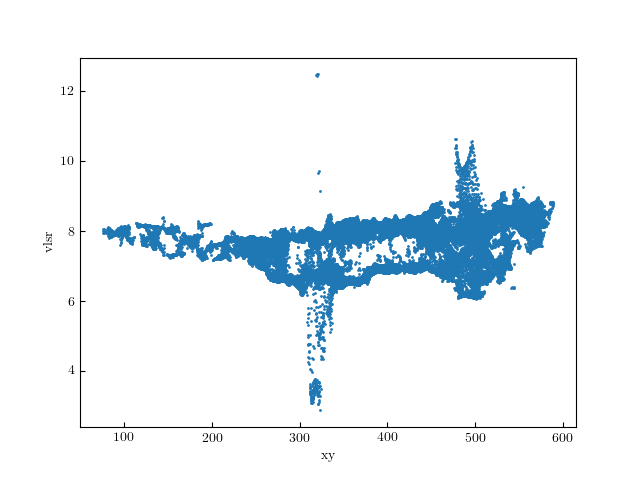

In [7]:
ds_feats.plot.scatter(x='xy', y='vlsr', s=1)


In [8]:
# sns.pairplot(ds_feats, kind='kde',diag_kind = 'kde', corner=True)
# plt.savefig('corner_plot.pdf')
# from this, maybe adding the amplitude could help

In [9]:
# fig = plt.figure(figsize=(6,6))
# ax = fig.add_subplot(111, projection='3d')
# ax.set_xlabel('x')
# ax.set_ylabel('y')
# ax.set_zlabel('vel')
# ax.scatter(xx_props, yy_props, cent_velocities, marker='.', alpha=0.02)

In [10]:
from sklearn.ensemble import IsolationForest


In [11]:
# we test Random forest to isolae the very high values of the outflows fitted.
clf = IsolationForest(max_samples=2000, random_state=42)
clf.fit(X)

IsolationForest(max_samples=2000, random_state=42)

In [12]:
ds_fit['outlier'] = clf.predict(X)

/tmp/ipykernel_4621/2049575606.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds_fit['outlier'] = clf.predict(X)


In [13]:
ds_fit_inlie = ds_fit[ds_fit['outlier']==1]
ds_fit_outlie =  ds_fit[ds_fit['outlier']==-1]

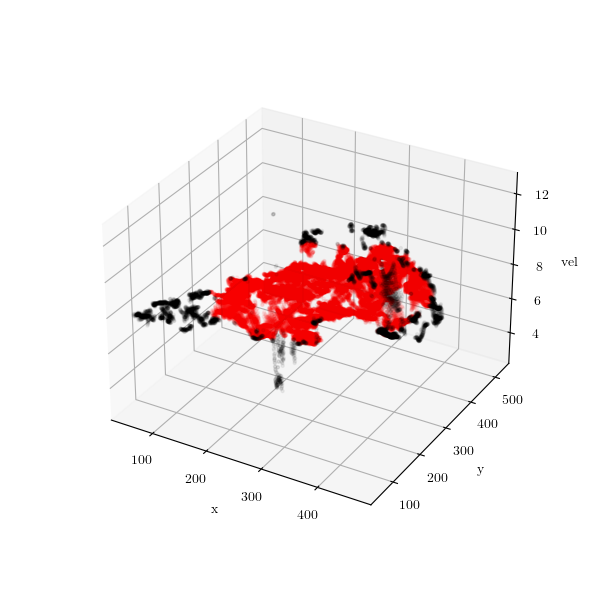

In [14]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('vel')
ax.scatter(ds_fit_inlie['x_pix'], ds_fit_inlie['y_pix'], ds_fit_inlie['vlsr'], marker='.', color='r', alpha=0.05)
ax.scatter(ds_fit_outlie['x_pix'], ds_fit_outlie['y_pix'], ds_fit_outlie['vlsr'], marker='.', color='k', alpha=0.05)

In [ ]:
from sklearn.inspection import DecisionBoundaryDisplay

In [ ]:
disp = DecisionBoundaryDisplay.from_estimator(
    clf,
    X,
    response_method="predict",
    alpha=0.5,
)
disp.ax_.scatter(X[:, 0], X[:, 1], s=2, alpha=0.1, edgecolor="k")
plt.colorbar(disp.ax_.collections[1])

In [ ]:
from sklearn.svm import OneClassSVM

In [ ]:
clf2 = OneClassSVM(nu=0.2).fit(X)


In [ ]:
disp = DecisionBoundaryDisplay.from_estimator(
    clf2,
    X,
    response_method="predict",
    alpha=0.5,
)
disp.ax_.scatter(X[:, 0], X[:, 1], s=2, alpha=0.1, edgecolor="k")
plt.colorbar(disp.ax_.collections[1])

## PCA decomposition

In [9]:
from sklearn.decomposition import PCA


In [7]:
pca = PCA(n_components=2)
X_r = pca.fit(X).transform(X)

In [8]:
pca.explained_variance_ratio_

array([0.40900694, 0.32722398])

In [12]:
pca.explained_variance_

array([1.22704352, 0.9816901 ])

In [13]:
pca.components_

array([[ 0.68399375,  0.67485026, -0.27700121],
       [ 0.15953852,  0.23214297,  0.95950878]])

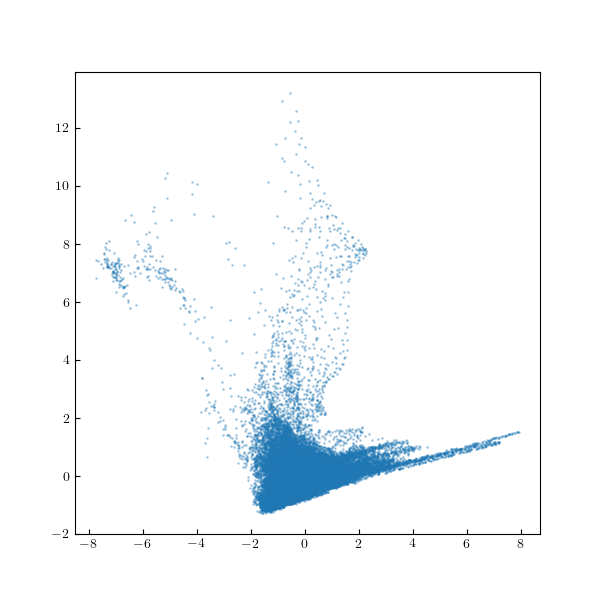

In [9]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.scatter(X_r[:,0], X_r[:,1], s=1, alpha=0.3)

In [10]:
# we also saw using glue that the clouds (red and blue) are defined by sigma_v <= 0.4

ds_sigmafilter = ds_feats.loc[(ds_feats['sigma_v']<=0.4) & (ds_feats['vlsr']<=9.1) & (ds_feats['vlsr']>6)]


<AxesSubplot: xlabel='vlsr', ylabel='sigma_v'>

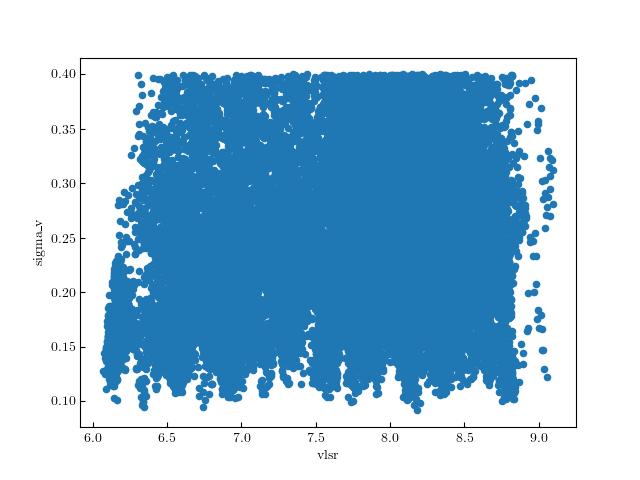

In [17]:
ds_sigmafilter.plot.scatter(x='vlsr', y='sigma_v')

In [12]:
ds_sigma_fit = ds_sigmafilter[['amplitude', 'vlsr', 'sigma_v']]

if normalize:
    X2 = StandardScaler().fit_transform(ds_sigma_fit)
else:
    X2 = ds_sigma_fit.values

In [13]:
pca2 = PCA(n_components=2)
X_r2 = pca2.fit(X2).transform(X2)

In [14]:
pca2.explained_variance_ratio_

array([0.42455005, 0.34698822])

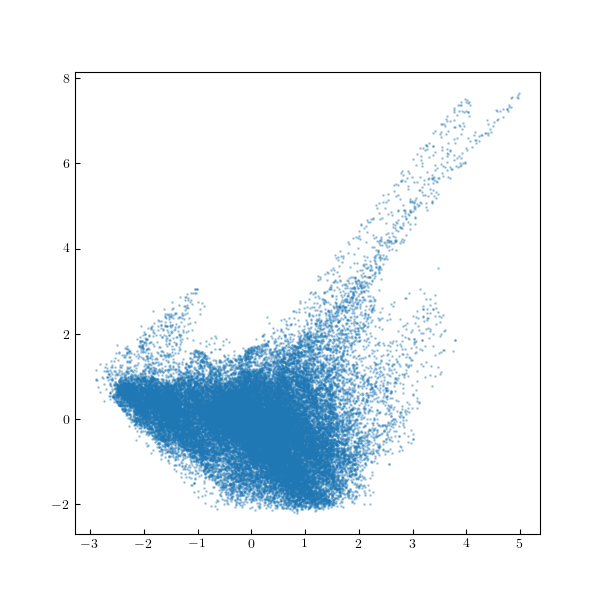

In [15]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.scatter(X_r2[:,0], X_r2[:,1], s=1, alpha=0.3)